In [40]:
import pandas as pd
df = pd.read_csv("TrazasHP_Eventos_Febrero.csv", delimiter=';')

In [41]:
level_filtered = df[df['Value.EventType'].str.contains('InicioNivelEvent') | df['Value.EventType'].str.contains('MuerteJugadorEvent') | df['Value.EventType'].str.contains('RecibirDanoEvent')]

from collections import defaultdict
# Guarda la vida perdida por run y por persona
lost_hp = defaultdict(list)
# Guarda los niveles que ha empezado por run y por persona
lvl_played_run = defaultdict(list)
# Al final se dividiran para extraer la vida perdida por nivel por run

run = 0
current_sid = ''
for ind in level_filtered.index:
    a = str(level_filtered['Name'][ind])
    if a not in current_sid:
        run = 0
        current_sid = a
        
    # Cada InicioNivelEvent suma un nivel al total en esa run
    if 'InicioNivelEvent' in level_filtered['Value.EventType'][ind]:
        # Cuando esta vacio o se aumenta de run, se hace un append a la lista
        if not lvl_played_run[a]:
            lvl_played_run[a].append(1)
        elif len(lvl_played_run[a]) is run:
            lvl_played_run[a].append(1)
        else:
            lvl_played_run[a][run] += 1
            
    elif 'RecibirDanoEvent' in level_filtered['Value.EventType'][ind]:
        if not lost_hp[a]:
            lost_hp[a].append(1)
        elif len(lost_hp[a]) is run:
            lost_hp[a].append(1)
        else:
            lost_hp[a][run] += 1
    
    # La unica manera de acabar la run es muriendo, asi se pasa a la siguiente
    elif 'MuerteJugadorEvent' in level_filtered['Value.EventType'][ind]:
        run += 1

In [42]:
# Estructura final que guarda vida perdida por nivel, con tantas entradas como runs
hp_level_runs = defaultdict(list)

for ind in lost_hp:
    aux = []
    if lvl_played_run[ind] and lost_hp[ind]:
        for i in range(0,len(lost_hp[ind])):
            aux.append(lost_hp[ind][i]/ lvl_played_run[ind][i])
        hp_level_runs[ind] = aux

In [62]:
df_forms = pd.read_csv("TrazasHP_Forms_Febrero.csv", delimiter=';')
skills = df_forms[['Name','Value.Skill', 'Value.levelDifficulty']].dropna()

skillsIDsEASY = defaultdict(list)
skillsIDsHARD = defaultdict(list)

for ind in skills.index:
    if skills['Name'][ind] != 3976523808826057435:
        skillsIDsEASY[skills['Name'][ind]].append(skills['Value.Skill'][ind])
        
print(skillsIDsEASY)

defaultdict(<class 'list'>, {1126757909184086875: [4.0, 2.0], 1947931233209809877: [2.0], 3222661888180467937: [4.0], 5116002334978996940: [1.0], 6409546622230072682: [3.0, 2.0, 2.0], 7405794501571521397: [2.0], 1082263944345942605: [3.0, 4.0], 1363855555257604925: [1.0], 1431444237905285619: [3.0, 2.0, 3.0], 1495074927818773988: [1.0, 3.0], 1543718511737675472: [3.0], 1798143173085778405: [4.0], 2009426020896778108: [2.0], 2059247330903277553: [2.0], 2917491179643285369: [2.0], 2937131431167305652: [1.0], 3407025067876679734: [2.0], 3542414199924367283: [3.0], 3649631126003791322: [3.0], 3856262804097269760: [5.0], 3866215995876012206: [4.0], 387455208773417305: [3.0, 2.0], 3925221362123969843: [3.0, 4.0], 3998890979124306452: [3.0], 4020079134643406323: [3.0], 4187895149841116080: [1.0], 4223473155689807984: [1.0], 4518381725033305616: [3.0], 4810893318553384374: [3.0], 5133188808210902934: [2.0], 5643948663400874549: [3.0, 4.0, 3.0], 602098375652577031: [2.0], 6174304818243345968: [

coefficient of determination: 0.031360870694089216


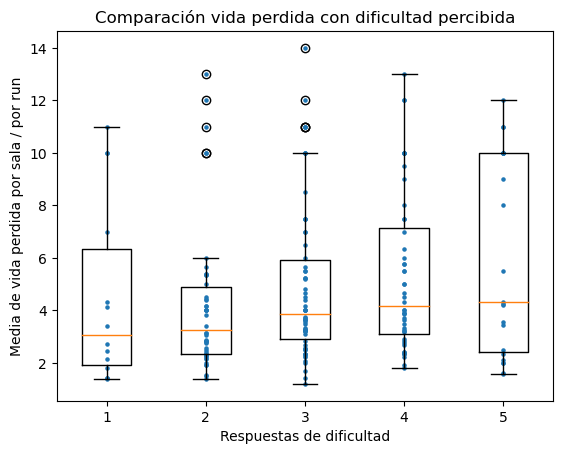

In [64]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

x = []
y = []

for ind in skillsIDsEASY:
    for i in range(0,len(skillsIDsEASY[ind])):
        if skillsIDsEASY[ind] and hp_level_runs[str(ind)]:
            x.append(skillsIDsEASY[ind][i])
            y.append(hp_level_runs[str(ind)][i])

# Linear regression
y_fit = np.array(y).reshape((-1,1))
x_fit = np.array(x)

model = LinearRegression()
model.fit(y_fit,x_fit)
r_sq = model.score(y_fit,x_fit)
print(f"coefficient of determination: {r_sq}")
x_pred = np.array([1,5])
y_pred = model.predict(x_pred.reshape((-1,1)))
# Fin Linear regression
            
data = [[],[],[],[],[]]

for i in range(0,len(x)):
    data[int(x[i]) - 1].append(y[i])

#plt.axline((x_pred[0],y_pred[0]),(x_pred[1],y_pred[1]), color="red")
plt.boxplot(data)
plt.scatter(x,y, s=5)

plt.xlabel("Respuestas de dificultad")
plt.ylabel("Media de vida perdida por sala / por run")
plt.title("Comparación vida perdida con dificultad percibida")


plt.savefig("Resultados/Vida-Forms.pdf", format="pdf", bbox_inches="tight")
plt.show()